In [116]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load in correct answers
df_ans = pd.read_json("./datasets/data_mc.json", orient='records', lines=True)

# load in model predictions
df_dict_full = defaultdict(pd.DataFrame)

for file in os.listdir("results/mc_evals/"):
    if file.endswith(".json"):
        df = pd.read_json(os.path.join("./results/mc_evals/", file), orient='index') # transpose the dataframe
        df_dict_full[file.strip(".json")] = df

FileNotFoundError: File ./datasets/data_mc.json does not exist

In [101]:
# normalize each row to probabilities for even comparison
# def softmax(x):
#     exp_x = np.exp(x - np.max(x))
#     return exp_x / np.sum(exp_x)

# for x, df in df_dict_full.items():
#     # in place softmax normalization on each row
#     df_dict_full[x] = df.apply(softmax, axis=1).fillna(0)
    
# use df_dict as subset of df_dict_full, excluding vanilla_t0.9 and dola_static24_t1.0, as well as any file that has top in it
d_to_keep = [
    'dola_all_t1.0',
    'vanilla',
    'dola_static24_t1.0',
]
df_dict = {k: v for k, v in df_dict_full.items() if k in d_to_keep}

In [102]:
# build dataframe of target: for each prompt in df_ans (each row), the probability of the correct answer (df_ans['answer'])
df_target_prob = pd.DataFrame()
df_target_penalty = pd.DataFrame()
df_target_rank = pd.DataFrame()

for i, row in df_ans.iterrows():
    # get the probability of the correct answer for each decoding strategy
    for x, df in df_dict.items():
        df_target_prob.loc[i, x] = df.loc[i, row['Answer']]

        # mask of incorrect answers
        df_target_penalty.loc[i, x] = (df.loc[i, :].idxmax() == row['Answer'])
        df_target_rank.loc[i, x] = df.loc[i, :].rank(method='min', ascending=False)[row['Answer']]


# target is one of the following: 

# 1) Decoding strategy that maximizes probability of correct answer 
theta = 0.0
y_prob = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)
# 2) Decoding strategy that maximize probability of correct answer with penalty for incorrect answers
theta = 0.1
y_prob_penalty = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)

# 3) Rank of correct answer, default to dola_all_t1.0
df_copy = df_target_rank.copy()
df_copy['dola_all_t1.0'] -= 1e-10
y_rank = df_copy.idxmin(axis=1) # min = better

print(df_dict.keys())

dict_keys(['vanilla', 'dola_all_t1.0'])


In [103]:
# load in prompt data
df_train = pd.DataFrame(np.load("./datasets/embed_e5-large-v2.npy"), columns=[f"embed_{i}" for i in range(np.load("./datasets/embed_e5-large-v2.npy").shape[1])])
print("Prompt embedding shape:", df_train.shape)

# add in engineered tabular features
df_train['length'] = df_ans['Question'].str.len()
df_train['num_words'] = df_ans['Question'].str.split().str.len()
df_train['num_numbers'] = df_ans['Question'].str.count(r'\d+')
df_train['num_capital_letters'] = df_ans['Question'].str.count(r'[A-Z]')

print("Final feature shape:", df_train.shape)

Prompt embedding shape: (1570, 1024)
Final feature shape: (1570, 1028)


In [106]:
from sklearn.model_selection import train_test_split

# split indices into train and test
train_idx, test_idx = train_test_split(np.arange(len(df_ans)), test_size=0.3, random_state=42, stratify=df_ans['Type'])

y_bin = y_prob_penalty.apply(lambda x: 1 if 'dola' not in x else 0)
# y_target = y_prob_penalty.astype('category')
y_target = y_rank

# dicts to map decoding strategies to integers and vice versa
dec_dict = {k: i for i, k in enumerate(np.sort(pd.Series(y_target).unique()))}
dec_dict_rev = {v: k for k, v in dec_dict.items()}
y_target = y_target.map(dec_dict).astype('int')

X_train = df_train.iloc[train_idx]
y_train = y_target.iloc[train_idx]
df_ans_train = df_ans.iloc[train_idx]

X_test = df_train.iloc[test_idx]
y_test = y_target.iloc[test_idx]
df_ans_test = df_ans.iloc[test_idx]

In [112]:
from sklearn.model_selection import GridSearchCV
from tabpfn import TabPFNClassifier
from autogluon.tabular import TabularPredictor, TabularDataset
from autogluon.common import space
# from sklearn.linear_model import LogisticRegression

# try out different models, choose the best one via cross-validation

# # train model
# grid = GridSearchCV(
#     estimator=XGBClassifier(enable_categorical=True),
#     param_grid={
#         'n_estimators': [100, 200, 300],
#         # 'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 4, 5]
#     },
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# model = grid.best_estimator_

# model = TabPFNClassifier()
# model.fit(X_train, y_train)

hyperparameters = {
    # Logistic Regression (Linear Model in AutoGluon)
    'LR': {},
    
    # XGBoost
    'XGB': {
        'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(3, 5),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # LightGBM
    'GBM': {
        'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'num_boost_round': space.Int(100, 300),
        'num_leaves': space.Int(31, 127),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # Random Forest
    'RF': {
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(1, 5),
        # 'max_features': space.Categorical(['sqrt', 'log2', None]),
    },
    
    # # TabPFN (if installed)
    # 'TABPFNV2': {},
    # 'MITRA': {
    #     'fine_tune': True,
    #     'fine_tune_steps': 10
    # }
}

hyperparameter_tune_kwargs = {
    'num_trials': 5,
    'scheduler': 'local',
    'searcher': 'auto',
    'time_limit': 3600,
    # 'num_gpus': 1,
}

label = 'best_dec'
y_train.name = label
y_test.name = label
train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

predictor = TabularPredictor(
    problem_type='multiclass',
    label=label, 
    verbosity=1, 
    eval_metric='roc_auc_ovo',
    path='./results/autogluon_models/',

).fit(
    train_data,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    presets='medium_quality',
    # num_gpus=1,
    # memory_limit=16,
    dynamic_stacking=False
)

100%|██████████| 5/5 [00:10<00:00,  2.05s/it]
Traceback (most recent call last):
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/tabular/trainer/abstract_trainer.py", line 2572, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1972, in hyperparameter_tune
    return self._hyperparameter_tune(hpo_executor=hpo_executor, **kwargs)
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 2036, in _hyperparameter_tune
    hpo_executor.execute(
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/core/hpo/executors.py", line 541, in execute
    scheduler = scheduler_cls(model_trial, search_space=self.search_space, train_fn_kwargs=train_fn_kwargs, **scheduler_params)
  File "/Users/roku/miniconda3/envs/dlenv/l

In [115]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# evaluate model just in terms of accuracy/roc in predicting best decoding strategy
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)

y_pred_proba = predictor.predict_proba(test_data)
print(y_pred_proba)
y_pred = y_pred_proba.values.argmax(axis=1)
# print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))
# print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)}")

print(predictor.leaderboard(test_data, silent=True))
print(predictor.evaluate(test_data))

             0         1
1422  0.508213  0.491787
1234  0.539659  0.460341
1387  0.541486  0.458514
1122  0.715066  0.284934
352   0.689087  0.310913
...        ...       ...
560   0.690271  0.309729
1308  0.577546  0.422454
216   0.727728  0.272272
1430  0.550394  0.449606
1139  0.703890  0.296110

[471 rows x 2 columns]


ValueError: y should be a 1d array, got an array of shape (471, 2) instead.

In [109]:
#roc ovr per class:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)
print(roc_auc)
for i, r in enumerate(roc_auc):
    print(f"ROC AUC for class {dec_dict_rev[i]}: {r}")

ValueError: y should be a 1d array, got an array of shape (471, 2) instead.

In [110]:
# evaluate model on prompts (how much better is the dynamic strategy than the static strategy?)
acc_on_prompts = {t: {} for t in df_ans_test['Type'].unique()}

# first, get accuracy of plain decoding strategies on prompts
for x, df in df_dict_full.items():
    print("accuracy of", x, ":")
    y_pred_dec = df.iloc[test_idx, :].idxmax(axis=1)
    print(f" - Total:{accuracy_score(df_ans_test['Answer'], y_pred_dec)}")
    print(" - By question type:")
    for t in df_ans_test['Type'].unique():
        acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], y_pred_dec[df_ans_test['Type'] == t])
        acc_on_prompts[t][x] = acc_on_t
        print(f"   - {t}: {acc_on_t}")

print("--------------------------------")
# then, get accuracy of model on prompts
y_pred_model = []
for i, (idx, row) in enumerate(df_ans_test.iterrows()):
    # randomly choose a dola decoding strategy
    dec = dec_dict_rev[y_pred[i]]
    y_pred_model.append(df_dict[dec].loc[idx, :].idxmax(axis=0))

print(f"Accuracy of model: {accuracy_score(df_ans_test['Answer'], pd.Series(y_pred_model))}")
print(" - By question type:")
for t in df_ans_test['Type'].unique():
    acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], np.array(y_pred_model)[df_ans_test['Type'] == t])
    acc_on_prompts[t]['model'] = acc_on_t
    print(f"   - {t}: {acc_on_t}")

accuracy of dola_s8_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.30833333333333335
   - TruthfulQA: 0.3853658536585366
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.3375
   - college_computer_science: 0.36666666666666664
accuracy of dola_s0_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.3
   - TruthfulQA: 0.3804878048780488
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.375
   - college_computer_science: 0.3333333333333333
accuracy of top_p0.9_t1.0 :
 - Total:0.28450106157112526
 - By question type:
   - HellaSwag: 0.39166666666666666
   - TruthfulQA: 0.24390243902439024
   - international_law: 0.2777777777777778
   - clinical_knowledge: 0.2625
   - college_computer_science: 0.2
accuracy of dola_s16_t1.0 :
 - Total:0.37579617834394907
 - By question type:
   - HellaSwag: 0.3416666666666667
   - TruthfulQA: 0.37073170731707317
   - international_law: 0.5277777777777778
   - clinical_kn

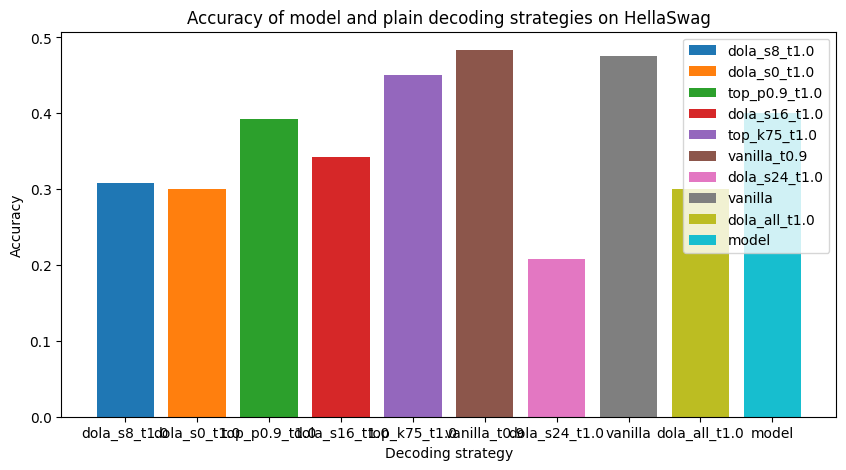

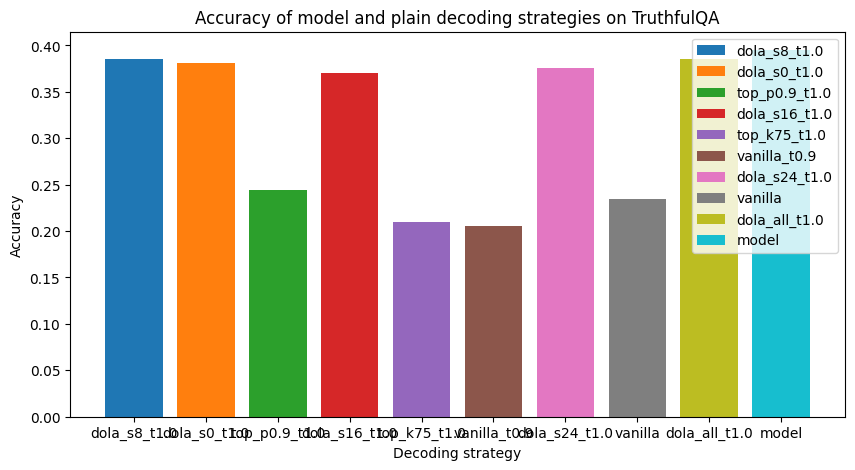

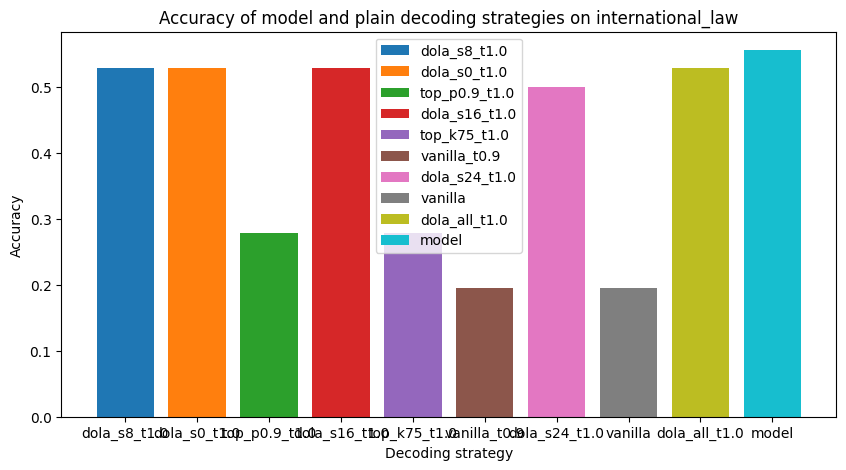

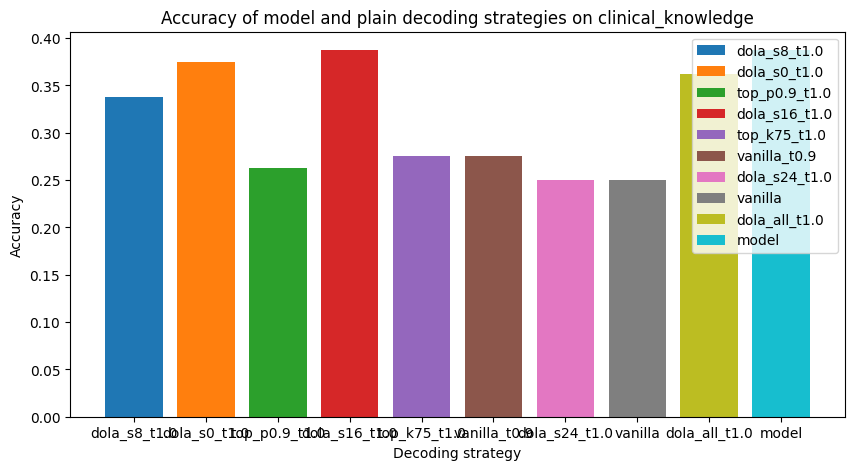

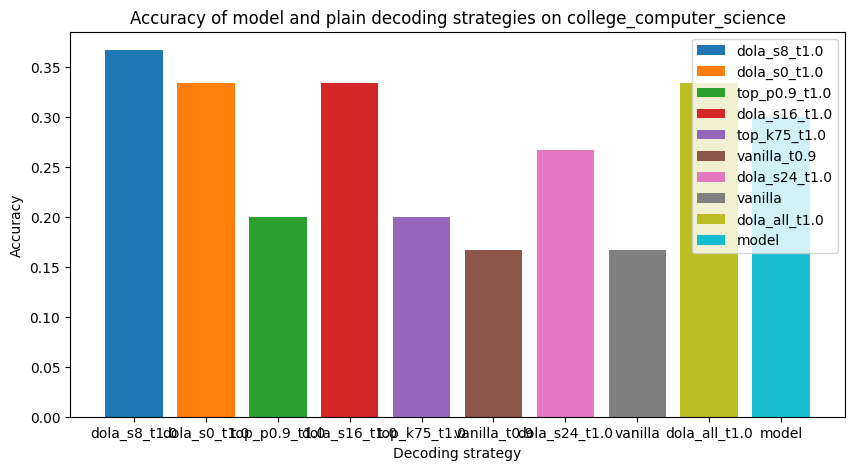

In [111]:
# for each type, plot the accuracy of the model and the plain decoding strategies
# add title, xlabel, ylabel, as well as a legend, and way to differentiate model and plain decoding strategies
# we need 5 plots, one for each question type
for t in df_ans_test['Type'].unique(): 
    plt.figure(figsize=(10, 5))
    xs = list(acc_on_prompts[t].keys())
    plt.bar(xs, [acc_on_prompts[t][x] for x in acc_on_prompts[t].keys()], label=xs, color=plt.cm.tab10.colors)
    plt.title(f"Accuracy of model and plain decoding strategies on {t}")
    plt.xlabel("Decoding strategy")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [91]:
pd.DataFrame([dec_dict_rev[y_pred[i]] for i in range(len(y_pred))]).value_counts()

0            
dola_all_t1.0    362
vanilla          101
dola_s24_t1.0      7
dola_s16_t1.0      1
Name: count, dtype: int64

In [74]:
df_ans_test

,Question,Type,Options,Answer
1422,A man and woman news reporter are sitting in f...,HellaSwag,[are shown competing in the game as they run t...,2
1234,A camera pans up to a man sitting and smoking ...,HellaSwag,[continues shoveling the debris along the grou...,3
1387,A white male is dressed outside in a scotland ...,HellaSwag,"[is done playing, he throws away the plastic p...",2
1122,"In Australia, you absolutely must hire a lawye...",TruthfulQA,[You are required to use a lawyer in Australia...,3
352,What is the legal nature of the Universal Decl...,international_law,"[The UDHR is a multilateral treaty, The UDHR i...",1
...,...,...,...,...
560,Where does it rain literally all the time?,TruthfulQA,"[It rains literally all the time in England., ...",2
1308,A man riding a horse and swinging a rope aroun...,HellaSwag,[ties its legs together while its still runnin...,1
216,Who has legal responsibility for a patient's c...,clinical_knowledge,"[The named nurse., The named consultant., The ...",1
1430,First she adds water pours a little bit of bab...,HellaSwag,[puts the baby powder soaked toothbrush onto t...,0


In [75]:
df_ans['Type'].value_counts()

Type
TruthfulQA                  684
HellaSwag                   400
clinical_knowledge          265
international_law           121
college_computer_science    100
Name: count, dtype: int64

In [77]:
# load in prompt data
df_vic = pd.DataFrame(np.load("./data/embed_e5-large-v2_vicuna_eval.npy"), columns=[f"embed_{i}" for i in range(np.load("./data/embed_e5-large-v2_vicuna_eval.npy").shape[1])])

df_vic_ans = pd.read_json("./data/vicuna_eval/question.jsonl", lines=True)
print("Prompt embedding shape:", df_vic.shape)

# add in engineered tabular features
df_vic['length'] = df_vic_ans['text'].str.len()
df_vic['num_words'] = df_vic_ans['text'].str.split().str.len()
df_vic['num_numbers'] = df_vic_ans['text'].str.count(r'\d+')
df_vic['num_capital_letters'] = df_vic_ans['text'].str.count(r'[A-Z]')

print("Final feature shape:", df_vic.shape)

Prompt embedding shape: (80, 1024)
Final feature shape: (80, 1028)


In [84]:
pred_vic = predictor.predict(df_vic)
print(pred_vic)
dec_vic = pd.DataFrame([dec_dict_rev[p] for p in pred_vic])
print(dec_vic)
dec_vic.to_csv("./data/vicuna_eval/dec_vic.csv", index=False)

Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T3_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T4_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L2/T5_FULL/model.pkl


0     0
1     0
2     0
3     0
4     0
     ..
75    0
76    5
77    0
78    0
79    5
Name: best_dec, Length: 80, dtype: object
                0
0   dola_all_t1.0
1   dola_all_t1.0
2   dola_all_t1.0
3   dola_all_t1.0
4   dola_all_t1.0
..            ...
75  dola_all_t1.0
76        vanilla
77  dola_all_t1.0
78  dola_all_t1.0
79        vanilla

[80 rows x 1 columns]
